# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
print(pyspark.__version__)
from pyspark.sql import SparkSession 
from pyspark.sql import functions as F 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from pyspark.sql.types import StringType
from pyspark.sql.functions import udf
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

2.4.3


In [2]:
# create a Spark session
spark = SparkSession\
    .builder\
    .appName("customer-churn")\
    .getOrCreate()

In [3]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# reading data from json
event_df = spark.read.json('mini_sparkify_event_data.json')

Lets just quicky view a portion of data

In [5]:
event_df.limit(10).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1538173362000,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


Looking for total number of events triggered

In [6]:
event_df.count()

286500

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [7]:
# any user is marked as churn if in future or in past, 
# he has cancelled subscription, say churn_event,
# i.e. triggered event Cancellation Confirmation

user_window = Window.partitionBy("userId")

event_df = event_df.withColumn("churn_event", F.when(F.col("page") == 'Cancellation Confirmation', 1).otherwise(0))
event_df = event_df.withColumn("churn", (F.sum('churn_event').over(user_window) > F.lit(0)).cast("int"))
event_df = event_df.drop("churn_event")

event_df.groupby("churn").count().show()

+-----+------+
|churn| count|
+-----+------+
|    1| 44864|
|    0|241636|
+-----+------+



### Explore Data

Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

printing schema of event df

In [8]:
event_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)



Printing number of users, artists, songs, pages, userAgent and itemInSession in dataset

In [9]:
event_df.agg(F.countDistinct("userId"), 
             F.countDistinct("artist"), 
             F.countDistinct("song"), 
             F.countDistinct("page"), 
             F.countDistinct("userAgent"), 
             F.countDistinct("itemInSession")).toPandas()

,count(DISTINCT userId),count(DISTINCT artist),count(DISTINCT song),count(DISTINCT page),count(DISTINCT userAgent),count(DISTINCT itemInSession)
0,226,17655,58480,22,56,1322


Describing the dataframe

In [10]:
event_df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778349,None,None,None,None,1.535358834085557E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104714E12,None,59682.02278593872,0.1565933682373473
2,stddev,1217.7693079161377,None,None,None,129.7672620114112,None,99.23517921058327,None,None,None,None,3.2913216163273053E9,726.7762634630808,NaN,31.50507848842204,1.5075439608197575E9,None,109091.94999910559,0.36341759209885743
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",,0
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99,1


- there are some nulls in dataframe, considering 286500 event count we got earlier, and looking for count row, we can see that most of the data is present
- we have some numeric as well as categorical vriable
- Some of them are:
    - categorical
        - auth
        - gender
        - level
        - method
        - page
        - status
        - userAgent
    - numeric
        - sessionId
        - itemInSession
        - length
        - timestamp

In [11]:
pd.set_option('display.max_colwidth', 500)

event_df.agg(F.collect_set("auth"), 
             F.collect_set("gender"), 
             F.collect_set("level"), 
             F.collect_set("method"), 
             F.collect_set("status"), 
             F.collect_set("page")).toPandas()

,collect_set(auth),collect_set(gender),collect_set(level),collect_set(method),collect_set(status),collect_set(page)
0,"[Logged In, Cancelled, Logged Out, Guest]","[F, M]","[free, paid]","[PUT, GET]","[404, 307, 200]","[Login, Submit Downgrade, Thumbs Down, Add to Playlist, NextSong, Submit Registration, Upgrade, Logout, Thumbs Up, Register, Add Friend, Help, Submit Upgrade, Cancellation Confirmation, Downgrade, Error, Cancel, Home, About, Save Settings, Settings, Roll Advert]"


Lets look at the browser used

In [12]:
event_df = event_df.withColumn("browser", F.split("userAgent", '/').getItem(0))
event_df.select("browser").distinct().show(20, False)

+--------+
|browser |
+--------+
|null    |
|Mozilla |
|"Mozilla|
+--------+



Seems like only mozilla used to access sparkify. Could not be important as feature.

Looking for the devices

In [ ]:
substr = udf(lambda x: x[1:].strip(" ") if x is not None else "",StringType())

event_df = event_df.withColumn("device", substr(F.split(F.split("userAgent", ' ').getItem(1), ';').getItem(0)))
event_df.select("device").distinct().show(20, False)

Sparkify is accessed using devices like: iPad, iPhone, Macintosh, Windows. Could be useful to dig deeper for churn using these devices.

#### Catgorical Variables

Lets just look at the different type of events trgiggered by users through these categorical columns

In [ ]:
def pivot_table_on_filter(df, filters):
    """ calculates count of event after applying each filter
        Input: 
            df - event dataframe
            filters - list of filters to be used on df
        Output:
            filtered_event_count: filtered event count of each user and churn
    """
    new_columns = [F.sum(F.when(f,F.lit(1)).otherwise(0)).alias(str(f).strip('Column<b''>')) for f in filters]
    filtered_df = df\
        .groupby("userId", "churn")\
        .agg(*new_columns)
    
    return filtered_df

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


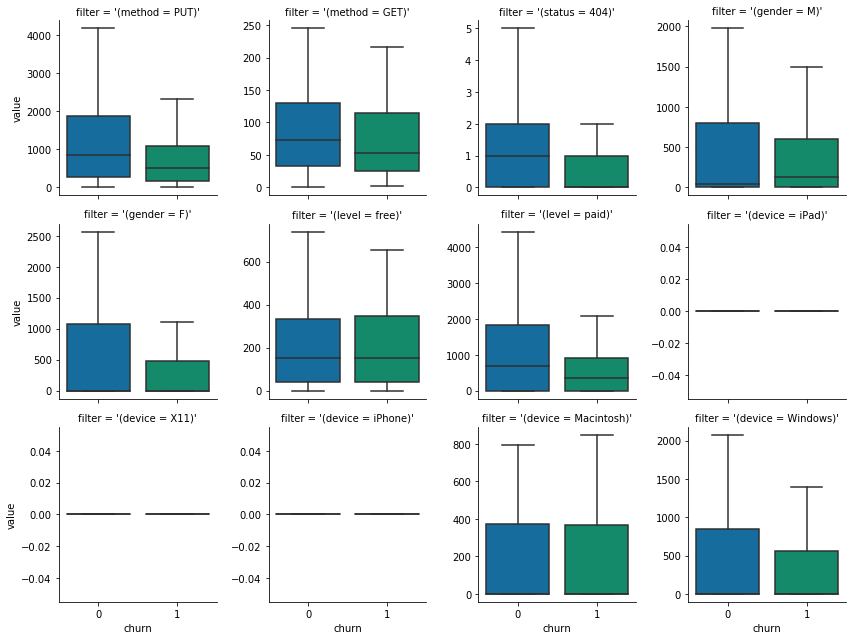

In [15]:
filters = [F.col("method")=='PUT',
           F.col("method")=='GET', 
           F.col("status")==404, 
           F.col("gender")=='M', 
           F.col("gender")=='F',
           F.col("level")=='free',
           F.col("level")=='paid',
           F.col("device")=='iPad', 
           F.col("device")=='X11', 
           F.col("device")=='iPhone',
           F.col("device")=='Macintosh',
           F.col("device")=='Windows',
          ]

categorical_events = pivot_table_on_filter(event_df, filters).toPandas()

dfm = categorical_events.drop('userId', axis=1).melt(['churn'], var_name='filter')
g = sns.FacetGrid(dfm, col='filter', col_wrap=4, sharey=False, sharex=True)
g = (g.map(sns.boxplot, 'churn','value',palette='colorblind', showfliers = False))
plt.tight_layout()
plt.show()

Some Observation:
- put method is used by non-churned user more.
- GET method is almost same among both groups.
- status 404 is hit less by churned users.
- Male users are more prone to churn than female users
- paid users are less likely to churn
- there is variation for windows device users

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


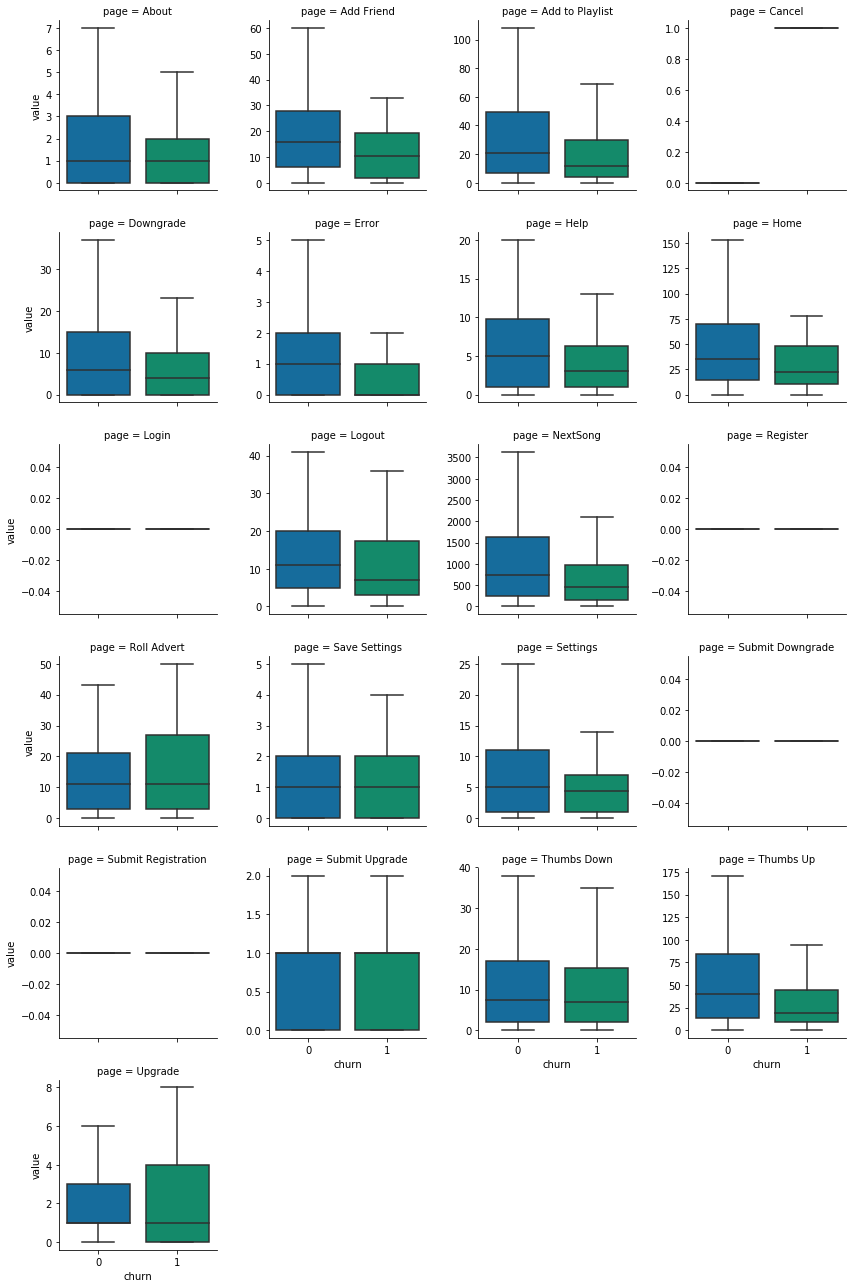

In [16]:
page_events = event_df.groupby("userId").pivot("page").count().fillna(0).drop("Cancellation Confirmation")
churn_data = event_df.select("userId", "churn").distinct()
page_events = page_events.join(churn_data, ['userId']).toPandas()

dfm = page_events.drop('userId', axis=1).melt(['churn'], var_name='page')
g = sns.FacetGrid(dfm, col='page', col_wrap=4, sharey=False, sharex=True)
g = (g.map(sns.boxplot, 'churn','value',palette='colorblind', showfliers = False))

plt.tight_layout()
plt.show()

Some Observation
1. churned users are less likely to visit :
    - "About", 
    - "Add Friend", 
    - "Add to Playlist", 
    - 'Downgrade', 
    - 'Error', 
    - 'Help', 
    - 'Home', 
    - 'NextSong', 
    - 'Settings', 
    - 'Thumbs Up'
    
2. and more likely to visit:
    - 'Roll Advert',
    - 'Upgrade'

#### Numerical Columns

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


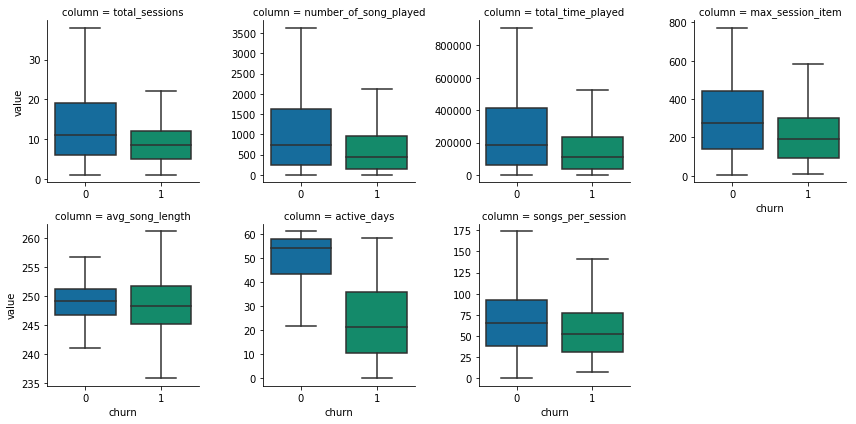

In [17]:
numerical_df = event_df.groupby("churn", "userId")\
    .agg(F.countDistinct("sessionId").alias("total_sessions"), 
         F.sum(F.when(F.col("page") == "NextSong", 1).otherwise(0)).alias("number_of_song_played"),
         F.sum("length").alias("total_time_played"),
         F.expr("max(distinct(sessionId, itemInSession).itemInSession) as max_session_item"),
         F.mean("length").alias("avg_song_length"),
         ((F.max("ts")-F.min("ts"))/(24*60*60*1000)).alias("active_days")
        )\
    .withColumn("songs_per_session", F.col("number_of_song_played")/F.col("total_sessions")).toPandas()

dfm = numerical_df.drop('userId', axis=1).melt(['churn'], var_name='column')
g = sns.FacetGrid(dfm, col='column', col_wrap=4, sharey=False, sharex=False)
g = (g.map(sns.boxplot, 'churn','value',palette='colorblind', showfliers = False))

plt.tight_layout()
plt.show()

Observations:
- less sessions are created by churned users
- less songs are played by churned users
- consequently less total play time of churned users
- also the churn users has less items in a session
- there is a lot of variation in song lenght of churn users
- active days is very low for churn users
- overall the the activity/interaction with key features of sparkify is less for churned users

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Based on the EDA, I have chosen following Feature lists:
     1. Page visit count features
        - about page visit count
        - add friend visit count
        - Add to playlist visit count
        - Downgrade page visit count
        - Error page visit count
        - home page visit count
        - roll advert count
        - help page visit count
        - settings page visit count
        - thumps up count
        - Upgrade count
    2. Key activity features
        - total_sessions
        - number of songs played
        - total time spent playing songs
        - maximum number of activity in a session
        - average length of song played
        - active days on the platform
        - average number of song played per session
        - songs played in free tier
        - songs played in paid tier
    3. Other features
        - faced 404 status code
        - weather PUT method used
        - user's gender
        - device used 
   

1. Page visit count features

In [18]:
def calc_page_visit_features(df):
    """ calculation of page visit count features
        Input: 
            df - event dataframe with page and userId
        Output:
            page_visit_features: page visit feature by each user
    """
    page_visit_features = df.groupby("userId")\
        .pivot("page")\
        .count()\
        .fillna(0)\
        .select("userId", 
              "About", 
              "Add Friend", 
              "Add to Playlist", 
              'Downgrade', 
              'Error', 
              'Help', 
              'Home', 
              'Roll Advert', 
              'Settings', 
              'Thumbs Up', 
              'Upgrade')
    return page_visit_features

2. Key activity features

In [19]:
def calc_activity_feature(df):
    """ calculation of key activity features
        Input: 
            df - event dataframe
        Output:
            key_activity_features: key_activity_features of each user
    """
    activity_feature = df.groupby("userId")\
        .agg(F.countDistinct("sessionId").alias("total_sessions"), 
             F.sum(F.when(F.col("page") == "NextSong", 1).otherwise(0)).alias("number_of_song_played"),
             F.sum("length").alias("total_time_played"),
             F.expr("max(distinct(sessionId, itemInSession).itemInSession) as max_session_item"),
             F.mean("length").alias("avg_song_length"),
             ((F.max("ts")-F.min("ts"))/(24*60*60*1000)).alias("active_days")
            )\
        .withColumn("songs_per_session", F.col("number_of_song_played")/F.col("total_sessions"))
    
    
    free_song_played = df.filter(F.col("page")=="NextSong")\
                        .filter(F.col("level")=="free")\
                        .groupby("userId").count()\
                        .withColumnRenamed("count", "free_song_played")
    
    paid_song_played = df.filter(F.col("page")=="NextSong")\
                        .filter(F.col("level")=="paid")\
                        .groupby("userId").count()\
                        .withColumnRenamed("count", "paid_song_played")
    
    key_activity_features = activity_feature\
                                .join(free_song_played, "userId")\
                                .join(paid_song_played, "userId")\
                                .fillna(0)
    
    return key_activity_features

3. Other features
    - times faced 404 status code
    - times PUT method used
    - device used 

In [20]:
def pivot_table_on_filter(df, filters):
    """ calculates count of event after applying each filter
        Input: 
            df - event dataframe
            filters - list of filters to be used on df
        Output:
            filtered_event_count: filtered event count of each user
    """
    new_columns = [F.sum(F.when(f,F.lit(1)).otherwise(0)).alias(str(f).strip("Column<b'( )'>")) for f in filters]
    filtered_event_count = df\
        .groupby("userId")\
        .agg(*new_columns)\
        .fillna(0)
    
    return filtered_event_count

def calc_device_features(df):
    """ calculation of device feature, method used and 404 status features
        Input: 
            df - event dataframe
        Output:
            device_features: device features of each user
    """
    filters = [F.col("method")=='PUT',
               F.col("status")==404,
               F.col("device")=='iPad', 
               F.col("device")=='X11', 
               F.col("device")=='iPhone',
               F.col("device")=='Macintosh',
               F.col("device")=='Windows',
              ]

    device_features = pivot_table_on_filter(df, filters)

    device_columns = ['device = iPad', 'device = X11', 'device = iPhone', 'device = Macintosh', 'device = Windows']
    for col in device_columns:
        device_features = device_features.withColumn(col, F.when(F.col(col) > 0, F.lit(1)).otherwise(F.lit(0)))

    return device_features

Combining all 3 sets of features

In [21]:
def calc_features(df):
    """ a wrapper function which combines all 3 set of features
        Input: 
            df - event dataframe
        Output:
            final_features: final feature after combining page visit features,
                            activity features, device features, churn data
    """
    churn_data = df.select("userId", "churn").distinct()
    page_visit_features = calc_page_visit_features(df)
    activity_feature = calc_activity_feature(df)
    device_features = calc_device_features(df)
    
    final_features = page_visit_features\
                        .join(activity_feature, "userId")\
                        .join(device_features, "userId")\
                        .join(churn_data, "userId")\
                        .fillna(0)
    
    return final_features

In [22]:
features = calc_features(event_df)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [23]:
# spliting data into test and train
features = features.withColumnRenamed('churn', 'label')
training, test = features.randomSplit([0.8, 0.2])

In [24]:
features.printSchema()

root
 |-- userId: string (nullable = true)
 |-- About: long (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- Downgrade: long (nullable = true)
 |-- Error: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Roll Advert: long (nullable = true)
 |-- Settings: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- Upgrade: long (nullable = true)
 |-- total_sessions: long (nullable = false)
 |-- number_of_song_played: long (nullable = true)
 |-- total_time_played: double (nullable = false)
 |-- max_session_item: long (nullable = true)
 |-- avg_song_length: double (nullable = false)
 |-- active_days: double (nullable = false)
 |-- songs_per_session: double (nullable = false)
 |-- free_song_played: long (nullable = false)
 |-- paid_song_played: long (nullable = false)
 |-- ethod = PUT: long (nullable = true)
 |-- status = 404: long (nullable = true)
 |-- device = iPad: integer (

In [25]:
# Create vector from feature data
feature_names = features.drop('label', 'userId').columns
vec_asembler = VectorAssembler(inputCols = feature_names, outputCol = "features")

# Scaling features
scalar = MinMaxScaler(inputCol="features", outputCol="scaled_features")

# definining classifiers

dt = DecisionTreeClassifier(labelCol="label", 
                            featuresCol="scaled_features")

rf = RandomForestClassifier(featuresCol="scaled_features", labelCol="label",
                                numTrees = 40,  featureSubsetStrategy='sqrt')

lr = LogisticRegression(featuresCol="scaled_features", labelCol="label", 
                        maxIter=20, regParam=0.02)

gbt = GBTClassifier(featuresCol="scaled_features", labelCol="label")

nb = NaiveBayes(smoothing=1.0, modelType="multinomial")


# Constructing Pipelines
pipeline_dt = Pipeline(stages=[vec_asembler, scalar, dt])
pipeline_rf = Pipeline(stages=[vec_asembler, scalar, rf])
pipeline_lr = Pipeline(stages=[vec_asembler, scalar, lr])
pipeline_gbt = Pipeline(stages=[vec_asembler, scalar, gbt])
pipeline_nb = Pipeline(stages=[vec_asembler, scalar, nb])

pipelines = [('decision Tree', pipeline_dt),
             ('random forest', pipeline_rf), 
             ('logistic regression', pipeline_lr),
             ('gradient boosting tree', pipeline_gbt),
             ('naive bayes', pipeline_nb)]

VectorAssembler doesn't handle null values, be sure to remove/fill naa values. I have filled it with 0 as my features are mostly counter/avg features and it makes sense to fill with 0.

In [26]:
fitted_models = [(name, pipe.fit(training)) for name, pipe in pipelines]

# Results

## Model Evaluation and Validation
If a model is used, the following should hold: The final model’s qualities — such as parameters — are evaluated in detail.

Some type of analysis is used to validate the robustness of the model’s solution. For example, you can use cross-validation to find the best parameters.

Show and compare the results using different models, parameters, or techniques in tabular forms or charts.

Alternatively, a student may choose to answer questions with data visualizations or other means that don't involve machine learning if a different approach best helps them address their question(s) of interest.

In [27]:
def evaluate_model(model, metric_name, test_data):
    """ Evaluation of model performance
        Input: 
            model - fitted model pipeline which can transform data
            metric_name - the metric to be used for model evaluation
            test_data - data/feature for the test set
        Output:
            score: the metric value on test_data
    """
    evaluator = MulticlassClassificationEvaluator(metricName = metric_name)
    predictions = model.transform(test_data)
    score = evaluator.evaluate(predictions)
    
    return score

In [28]:
# looping through each models and printing metric
test_scores = []
train_scores = []
model_name =[]

for name, model in fitted_models:
    test_metric = evaluate_model(model, 'f1', test)
    train_metric = evaluate_model(model, 'f1', training)
    test_scores.append(test_metric)
    train_scores.append(train_metric)
    model_name.append(name)
    
results = pd.DataFrame({"model": model_name,
                        "test F1":  test_scores,
                        "train F1": train_scores})

results

,model,test F1,train F1
0,decision Tree,0.869658,1.000000
1,random forest,0.782764,0.981545
2,logistic regression,0.798321,0.943710
3,gradient boosting tree,0.869658,1.000000
4,naive bayes,0.622396,0.588513


- Decision Tree and Gradient boosting method have almost same accuracy.
- logistic reg has average f1 score.
- While naive bayes is suffering a lot in terms of F1 score.
- Gradient boosting method is giving better result of 0.86 f1 score, 

Looking at the confusion matrix for Gradient boosting tree.

In [33]:
# extract gbt model
name, gbt_model = fitted_models[3]
# get the predictions on test data
predictions = rf_model.transform(test)

# calculate confusion matrix
confusion_matrix = predictions.groupby("label")\
                                   .pivot("prediction")\
                                   .count()\
                                   .toPandas()

confusion_matrix

,label,0.0,1.0
0,1,3,2
1,0,17,2


There are some 5 misclassification where, 3 of which churned users were predicted wrong and in 2 users were predicted churned. 

### Cross validation

Since the gradient boosting tree has given better f1 score.
Parameters of gradient boosting tree:
- maxDepth – Max number of levels in each decision tree

For cross validation maxDepth would be good enough

In [35]:
# creating param grid for gbt model
param_grid = ParamGridBuilder()\
                .addGrid(gbt.maxDepth, [int(x) for x in np.linspace(start = 3, stop = 7, num = 3)]) \
                .build()

# model evaluator with F1 score as metric
model_evaluator = MulticlassClassificationEvaluator(metricName = 'f1')

# initializing cross validator with paramgrid, model pipline and model_evaluator
crossval = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=param_grid,
                          evaluator=model_evaluator,
                          numFolds=3)

# fitting model on train data
cv_model = crossval.fit(training)

# calculating the F1 score on test data
metric = evaluate_model(cv_model, 'f1', test)
print(f" F1 Score from cross validation: {metric}")

 F1 Score from cross validation: 0.8696581196581197


### Feature Importance

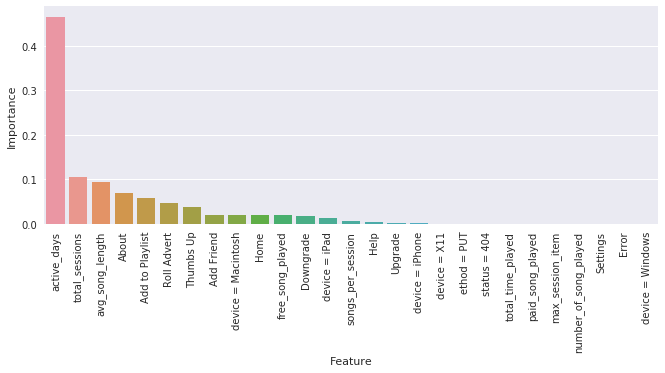

In [36]:
# best cv model
best_model_pipeline = cv_model.bestModel

# best model
best_model = best_model_pipeline.stages[-1]

# feature importance
importances = best_model.featureImportances

# making feature importance dataframe
feature_importance = pd.DataFrame({'Importance': importances,
                                   'feature': feature_names})\
                        .sort_values(by = 'Importance', ascending = False)

sns.set(rc={'figure.figsize':(11, 4)})
sns.barplot(x="feature", y="Importance", data=feature_importance)
plt.xticks(rotation = 90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.show()

### Best gbt model

In [37]:
print('maxDepth - ', best_rf_model.getOrDefault('maxDepth'))

maxDepth -  3


## Justification

After running the cross validation we can see that:
- Gradient Boosting Tree gives F1 score of 0.8696581196581197
- best maxDepth was found to be 3
- On feature side active_days, total_sessions, avg_song_length, About page visit count etc were found to be most important feature and number of song played, paid song played, Error page visit, device=Windows to be least important feature.


# Conclusion

## Reflection

Churn prediction is an important problem in industry. It is not a surprise that old customers bring more revenue to a brand than a new customer. Adding to that acquiring customer is equally costly. In this project I have made a model for churn prediction of a music company, 'Sparkify' which provides music streaming services.

On Trying with 5 different models, I have seen that Gradient boosting method appears to work best as its f1 score is better than other options. 

From feature importance we can see that active_days, total_sessions, avg_song_length, About page visit count etc were found to be most important feature and number of song played, paid song played, Error page visit, device=Windows to be least important feature. 

Spark ML is a very powerful tool for machine learning. It provides all the model, feature transformation we can use for various types of problem statements. Like sklearn, we can build pipelines here and do cross validation in a distributed way. Thus, it provides end to end model development lifecycle in a distributed way. This can be particularly useful if we have 100s of gigabytes of data.

## Improvement

Since we now know the most important features, we can try training on the subset of the total features sorted in descending order of importance. This will reduce time and should get the same accuracy. It will also make the model lighter.

More features can be added to the model, like user artist interaction, or how many times user has played a popular/trending song.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.